# Face Recognition #8

- We are using: FaceRecs
- We are totally re-thinking about parameters

In [3]:
import argparse
import pickle
import cv2
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os
import dlib
import matplotlib.pyplot as plt
import numpy as np
import time
import random

print(dlib.DLIB_USE_CUDA)
#dlib.DLIB_USE_CUDA = True

True


In [4]:
import json
root_path = "./"
with open( root_path +'labelled_videos.json') as json_file:
    data_json = json.load(json_file)
    
def readTrueName(rec_name):
    if( data_json is None):
        return "Error"
    for real_name in data_json:
        if rec_name in data_json[real_name]:
            return real_name
    return "unknown"

In [5]:
import os
import numpy as np

def computeFAR(FAR_path, values):
    log_folder = FAR_path
    files = os.listdir(log_folder)


    confirmed_rate = np.zeros(len(values))
    i = 0

    for thr in values:
        total_files = 0
        recognized = 0
        notdetected = 0
        wrong = 0
        wrong_confirmed = 0
        wrong_confirmed2 = 0
        wrong_confirmed3 = 0
        wrong_confirmed4 = 0

        ####
        one_wrong_rec = 0
        persons = 0
        for f in files:
            if( f.startswith('log') == True):
                filev = open(log_folder + f, "r")
                vector = f.split('_')[1].split(".")[0]
                correct_person = readTrueName(vector + ".webm")
                lines = filev.readlines()
                persons += 1
                for line in lines: 
                    #we don't want to make statistics on the same person
                    name = line.split(' ')[0] + ".webm"
                    if(readTrueName(name) == correct_person):
                        continue

                    total_files += 1

                    rec_flag = line.split(' ')[2]
                    rec_percentage = float(line.split(' ')[3])
                    notdec_percentage = float(line.split(' ')[4])
                    notrec_percentage = float(line.split(' ')[5])

                    recognized = recognized + rec_percentage
                    notdetected = notdetected + notdec_percentage
                    wrong = wrong + notrec_percentage

                    if(notrec_percentage > thr):
                        wrong_confirmed = wrong_confirmed + 1

        if(total_files == 0):
            total_files = 1
        confirmed_rate[i] = wrong_confirmed / total_files
        wrong_confirmed = 0
        i = i +1

    ## equal for each iteration
    positive = recognized / total_files 
    undetected = notdetected / total_files
    negative = wrong / total_files

    wrong_rec_on_persons = one_wrong_rec / (persons-1)
    return confirmed_rate

In [6]:
import numpy as np
import os

def computeTAR(TAR_path, values):
    files = os.listdir(TAR_path)
    confirmed_rateT = np.zeros(len(values))
    i=0

    for thr in values:
        total_files = 0
        recognized = 0
        notdetected = 0
        wrong = 0
        confirmed = 0
        total_files = 0

        for f in files:
            if( f.startswith('log') == True):
                filev = open(TAR_path + f, "r")
                lines = filev.readlines()
                for line in lines:
                    total_files += 1

                    try:
                        rec_flag = line.split(' ')[2]
                        rec_percentage = float(line.split(' ')[3])
                        notdec_percentage = float(line.split(' ')[4])
                        notrec_percentage = float(line.split(' ')[5])

                        recognized = recognized + rec_percentage
                        notdetected = notdetected + notdec_percentage
                        wrong = wrong + notrec_percentage
                        if(rec_percentage > thr):
                            confirmed = confirmed + 1

                    except IndexError:
                        print(line)

        confirmed_rateT[i] = confirmed / total_files

        positive = recognized / total_files 
        undetected = notdetected / total_files
        negative = wrong / total_files

        i = i + 1
    return confirmed_rateT

In [7]:
from sklearn.metrics import roc_curve, auc

def plotROCcurve(TAR_path, FAR_path, description="20_20_0.50"):
    values = [0.1, 0.5, 0.10, 0.20, 0.30, 0.40, 0.45, 0.55, 0.60, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]
    f = description.split("_")
    print("Embeddings train:",f[0])
    print("Embeddings test:",f[1])
    print("Tolerance:", f[2])
    fpr = computeFAR(FAR_path, values)
    tpr = computeTAR(TAR_path, values)
    exampleX = [0.0, 0.0000001, 0.2, 0.8, 1.0]
    exampleY = [0.0, 1.0, 1.0, 1.0, 1.0]
    limitx = np.max(fpr)

    plt.figure()
    lw = 2
    plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    lw = 2
    plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
    plt.scatter(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
    plt.scatter(fpr[5], tpr[5], color='red',lw=lw, label='thr: 0.4')
    plt.scatter(fpr[6], tpr[6], color='blue',lw=lw, label='thr: 0.45')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
    plt.xlim([-0.001, limitx+0.02])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Zooming in the ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    print("Threshold:", values[4], "TAR:", tpr[4], "FAR", fpr[4])
    print("Threshold:", values[5], "TAR:", tpr[5], "FAR", fpr[5])
    print("Threshold:", values[6], "TAR:", tpr[6], "FAR", fpr[6])
    print("Threshold:", values[7], "TAR:", tpr[7], "FAR", fpr[7])

### Histogram Face crop ratio

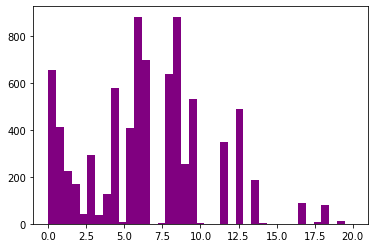

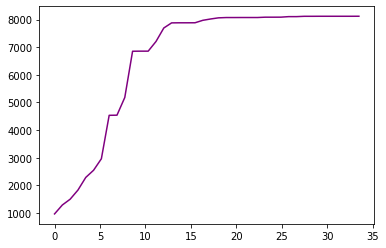

In [100]:
boxes_src = "./boxes/"
boxes_list = os.listdir(boxes_src)
v = []
for file in boxes_list:
    box = boxesRead(boxes_src + file)
    nums = box['ratio']
    for b in nums:
        v.append(b)

plt.hist(v, bins=np.linspace(0,20,40), color='purple')
plt.show()
values, base = np.histogram(v, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='purple')

### Bluriness evaluation
The higher the number the lower the noise.
We can try to discard using also noise values.

In [8]:
def readFrames(path):

    video = cv2.VideoCapture(path)
    count = 0
    frames = []
    while(1):
        ret, frame = video.read()
        if ret == True:
            frames.append(frame)
            count += 1
        else:
            break

    return frames

In [9]:
import cv2
from skimage.restoration import estimate_sigma

def estimate_noise(image_path):
    img = cv2.imread(image_path)
    return estimate_sigma(img, multichannel=True, average_sigmas=True)


def imageRead(path, show=True):
    # BGR FORMAT #
    image = cv2.imread(path)
    
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(show== True):
        plt.imshow(rgb)
        plt.show()
    return image

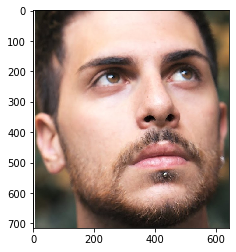

Noise: 0.4362666880431947


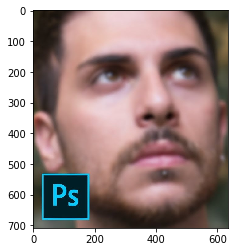

Noise: 0.27192924894751


In [10]:
value = estimate_noise("./Hres.jpg")
img = imageRead("./Hres.jpg")
print('Noise:', value)
value = estimate_noise("./Lres.jpg")
img = imageRead("./Lres.jpg")
print('Noise:', value)

Noise estimation on a reduced set of video

In [ ]:
noise = []
vidpath = "../#6/videos/"
vidlist = os.listdir(vidpath)

for v in vidlist:
    #frames = readFrames(vidpath + v)
    for f in frames:
        n = estimate_sigma(f, multichannel=True, average_sigmas=True)
        noise.append(n)

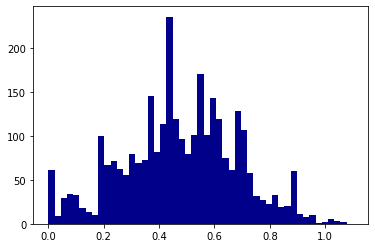

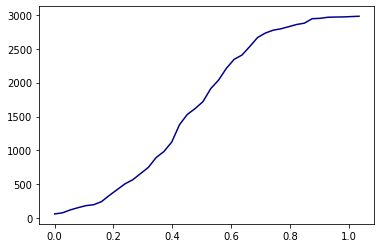

In [26]:
plt.hist(noise, bins=np.linspace(0,1.1,50), color='darkblue')
plt.show()
values, base = np.histogram(noise, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='darkblue')

## Possible solutions
- 1. Face crop correction with a different tolerance
- 2. Face crop correction using percentage of local maximum face ratio for each video
- 3. Face crop correction using percentage of local maximum and noise correction


Moreover, computing the closer encoding in a video corresponds to accepting the video just when just an encoding matches. In our code we can easily obtain that enlowering the threshold to 1/n_encs per video. 
We will plot the in ROC curve a possible solution using this scenario.

Embeddings train: 20
Embeddings test: 20
Tolerance: 0.45


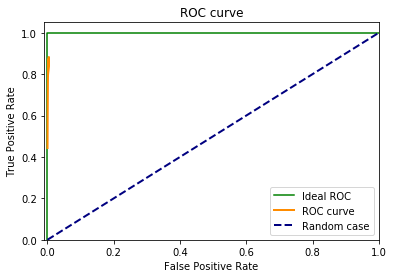

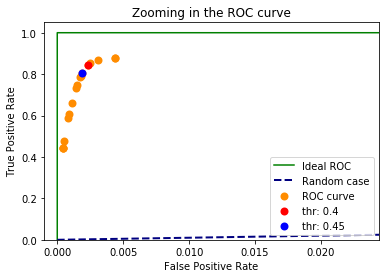

Threshold: 0.3 TAR: 0.852985713345184 FAR 0.0024680278214045323
Threshold: 0.4 TAR: 0.8460728158535783 FAR 0.0023221898137760827
Threshold: 0.45 TAR: 0.8048587793798143 FAR 0.0018398025577742877
Threshold: 0.55 TAR: 0.786951083020607 FAR 0.001738837783262284


In [18]:
log_basic_path = "./logs_0.45_area1.5/"
T_path = log_basic_path + "T/"
F_path = log_basic_path + "F/"
desc = "20_20_0.45"
plotROCcurve(T_path, F_path, desc)

### 1. Face crop correction with a different tolerance
They still contained 'documents' class.

Embeddings train: 20
Embeddings test: 20
Tolerance: 0.5


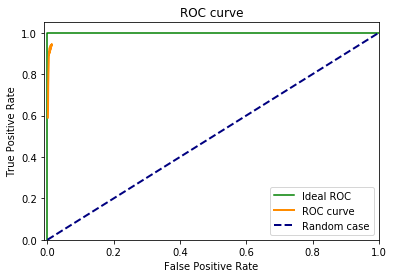

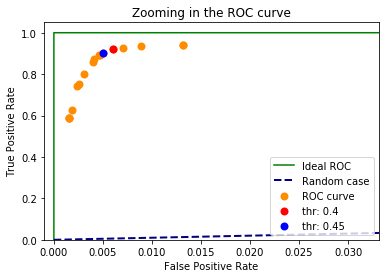

Threshold: 0.3 TAR: 0.9277766804924616 FAR 0.007033879291002917
Threshold: 0.4 TAR: 0.9235631048785305 FAR 0.006013013237603769
Threshold: 0.45 TAR: 0.9022318783330041 FAR 0.004980928875925511
Threshold: 0.55 TAR: 0.8941997498189479 FAR 0.0046331613192730535


In [19]:
log_basic_path = "./logs_0.5_area1.5/"
T_path = log_basic_path + "T/"
F_path = log_basic_path + "F/"
desc = "20_20_0.5"
plotROCcurve(T_path, F_path, desc)

### Noise encodings generation and test functions

In [27]:
def readFrames(path):

    video = cv2.VideoCapture(path)
    count = 0
    frames = []
    while(1):
        ret, frame = video.read()
        if ret == True:
            frames.append(frame)
            count += 1
        else:
            break

    return frames

def createEncodingsandBoxesFromVector(dataset_vector, name , detection = 'cnn'):

    # grab the paths to the input images in our dataset
    print("[INFO] quantifying faces...")
    '''
    We're going to take only a limit number of images to create the encodings.
    We'll take a random sample over all the images of a person and in particular
    '''
    boxfile = open("./boxes_n/box_" + name[:-5] + ".pkl", "wb")
    
    if len(dataset_vector )<= 0:
        print("AN ERROR OCCURRED FOR ",name)
        return

    images = random.choices(dataset_vector, k = num, )

    # initialize the list of known encodings and known names
    knownEncodings = []
    knownNames = []
    
    ratios = []
    face_areas = []
    image_areas = []
    noises = []
        
    # loop over the image paths
    for image in images:
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))

        # load the input image and convert it from RGB (OpenCV ordering)
        # to dlib ordering (RGB)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #estimate noise
        noise = estimate_sigma(rgb, multichannel=True, average_sigmas=True)
        # detect the (x, y)-coordinates of the bounding boxes
        # corresponding to each face in the input image
        boxes = face_recognition.face_locations(rgb,model=detection) 

        ######################### FACE RESOLUTION LOGIC
        for face_location in boxes:
            try:
                top, right, bottom, left = face_location
            except IndexError:
                top = right = bottom = left = 0

            area_face = (bottom-top) * (right-left)
            area_image = image.shape[0] * image.shape[1]
            ratio = area_face/area_image * 100
            #print('face:', area_face, 'image:', area_image, 'ratio:', ratio)

            ratios.append(ratio)
            face_areas.append(area_face)
            image_areas.append(area_image)
            noises.append(noise)
        #########################
        
        # compute the facial embedding for the face
        encodings = face_recognition.face_encodings(rgb, boxes)

        # loop over the encodings
        for encoding in encodings:
            # add each encoding + name to our set of known names and
            # encodings
            knownEncodings.append(encoding)
            knownNames.append(name)
    #pdb.set_trace()
    
    boxdata = {"ratio": ratios, "face": face_areas, "image": image_areas, "noise": noises}
    boxfile.write(pickle.dumps(boxdata))
    boxfile.close()

    
    # dump the facial encodings + names to disk
    print("[INFO] serializing encodings..." + name)
    data = {"encodings": knownEncodings, "names": knownNames}
    file_name = root_path + "encodings_" + str(num) + "/" + name[:-5] + '.pkl'
    
    print(len(knownEncodings))

    log_errors = False
    if( log_errors == True):
        if len(knownEncodings) > 25:
            f = open(root_path + "/encodings_face_videos/" + 'multiple_people.txt', 'a')
            f.write(name + '\n')
            f.close()
        if len(knownEncodings) <= 0:
            f = open(root_path + "/encodings_face_videos/" + 'not_recognisable.txt', 'a')
            f.write(name + '\n')
            f.close()
      

    f = open(file_name, "wb")
    f.write(pickle.dumps(data))
    f.close()

In [28]:
base_path = "../#6/videos/"
root_path = "./"
videos = os.listdir(base_path)
global_start = time.time()
count = 0
num = 21

count = 0
for video_name in videos:
    count += 1
    if(count < 0):
        continue
    start = time.time()
    frames = readFrames(base_path + video_name)
    createEncodingsandBoxesFromVector(frames, video_name)
    end = time.time()
    print(count/len(videos), 'Time_enc:', end-start)


global_end = time.time()
print('Time_enc:', global_end-global_start)

[INFO] quantifying faces...
[INFO] serializing encodings...rec-0048614e-6977-420f-96b9-2669e01b7b6a-xtlT3wU8hU-qR5OTs6cT0MYV1dP-1583832656032-video-face.webm
52
0.002824858757062147 Time_enc: 25.757744073867798
[INFO] quantifying faces...
[INFO] serializing encodings...rec-00f2215a-653a-41b0-a2bd-e081c2644b50-G9pr1rwdts-NHrbOczHA28ELIx0-1582012854590-video-face.webm
23
0.005649717514124294 Time_enc: 16.258535861968994
[INFO] quantifying faces...
[INFO] serializing encodings...rec-0158e178-671c-4f00-9d2c-4beb850fee5e-3JMlpKKcQI-AbKReuhN2e8lPpWU-1580377499206-video-face.webm
21
0.00847457627118644 Time_enc: 22.853872776031494
[INFO] quantifying faces...
[INFO] serializing encodings...rec-02775db9-2e4d-491a-ba5d-43fb715e0c3d-FA8nx738TZ-K7Nm6zOMFD0Q33Pc-1580810763795-video-face.webm
21
0.011299435028248588 Time_enc: 14.928064823150635
[INFO] quantifying faces...
[INFO] serializing encodings...rec-029c7345-eb65-4b22-aa68-4c7ad814ec4a-YYWgaS5LEb-Wfw34uhRwl8rKOAa-1582738555620-video-face.webm

[INFO] serializing encodings...rec-1a8c6bed-ebb0-4167-9c86-293d5fc5a12c-84pDQjlMXW-0P9fuZjlChhk0vDE-1582559205412-video-face.webm
21
0.11299435028248588 Time_enc: 20.825732946395874
[INFO] quantifying faces...
[INFO] serializing encodings...rec-1bfffc4c-678a-48fa-9d53-d17e8d71c9a1-1Y2XAnvhCP-tL8XWbXPrbmVowyg-1579697128993-video-face.webm
27
0.11581920903954802 Time_enc: 12.628455877304077
[INFO] quantifying faces...
[INFO] serializing encodings...rec-1c1ab680-70ce-41b2-915d-bb6c50d57cb6-6stHYiMeSE-ZHXAqo90xJlRjwXF-1580747229480-video-face.webm
21
0.11864406779661017 Time_enc: 19.448790550231934
[INFO] quantifying faces...
[INFO] serializing encodings...rec-1c1bf933-835b-49fd-a178-9ee0fefacc96-mYycDX0R3l-Rbg5Jfnaqje4NlcA-1581442309680-video-face.webm
20
0.12146892655367232 Time_enc: 17.51100754737854
[INFO] quantifying faces...
[INFO] serializing encodings...rec-1c3504ca-e652-40c2-8b77-1cd16174919b-oVcNnjQBu9-QlrzRM1VWHAZUKxU-1581443193377-video-face.webm
21
0.12429378531073447 Time_enc

[INFO] quantifying faces...
[INFO] serializing encodings...rec-32e61d8e-df52-48b2-b7a8-f7475c924690-E3qO5VOmIG-MGDSq50usWakuoP4-1580308985665-video-face.webm
21
0.22598870056497175 Time_enc: 22.00299835205078
[INFO] quantifying faces...
[INFO] serializing encodings...rec-33ef9576-1aaf-42bd-9efc-6341a1ff3fe3-Dquk8t8vFJ-a1ptgtuq6SniNgN3-1580226977654-video-face.webm
21
0.2288135593220339 Time_enc: 13.981651306152344
[INFO] quantifying faces...
[INFO] serializing encodings...rec-340dad65-ef53-4dc9-981f-580c288b5bd3-JunGKSfQ1N-VahVpXHetMSSUv8e-1584019913166-video-face.webm
21
0.23163841807909605 Time_enc: 22.523075819015503
[INFO] quantifying faces...
[INFO] serializing encodings...rec-3511aec3-cdbc-45d7-921b-9ef9377ac954-ky7M0w48oj-JowAz1Hoq65j8Rom-1582281454795-video-face.webm
34
0.2344632768361582 Time_enc: 29.300353288650513
[INFO] quantifying faces...
[INFO] serializing encodings...rec-36370ff1-4702-456a-9c19-0e50c05b6ce4-og5JnOM4t4-M99th3oAvtgAEPiN-1579706692147-video-face.webm
20
0.

[INFO] quantifying faces...
[INFO] serializing encodings...rec-4c542b14-af01-4bb0-9801-160c6ecb3995-vCdgzbMLoS-zds0NsUS6cUNr1Bl-1580813624338-video-face.webm
21
0.3389830508474576 Time_enc: 20.70166039466858
[INFO] quantifying faces...
[INFO] serializing encodings...rec-4d53ec51-6e12-4e47-b984-b66f65089908-SudjQ7bql4-V6GtOXUyzQRFkPVv-1582728910783-video-face.webm
0
0.3418079096045198 Time_enc: 33.4575834274292
[INFO] quantifying faces...
[INFO] serializing encodings...rec-4de496a3-e342-4228-91e0-1b02a56e10b9-IJLu9RjLKp-KmLETWKDh7yLf1IA-1581602029164-video-face.webm
14
0.3446327683615819 Time_enc: 16.363906383514404
[INFO] quantifying faces...
[INFO] serializing encodings...rec-4ea04509-9545-4a7b-91ca-02074bcd8f96-ZqzW90xqlO-wskRop8Mz1i5rwQ5-1580802550469-video-face.webm
21
0.3474576271186441 Time_enc: 12.455886363983154
[INFO] quantifying faces...
[INFO] serializing encodings...rec-4ee784c7-3480-4ee4-a72c-a0e06817f241-3sKFCoCHLH-QC80MiarInEm6vX0-1580463575852-video-face.webm
18
0.35028

[INFO] quantifying faces...
[INFO] serializing encodings...rec-733a06bd-c6b5-45f2-8142-1f2a8fdd7e9d-oDYE1JvjEQ-a9co53q42VwDufms-1580744115832-video-face.webm
21
0.4519774011299435 Time_enc: 12.480831146240234
[INFO] quantifying faces...
[INFO] serializing encodings...rec-73b1dccc-4ca1-46f5-8c78-b0ff2ecdc1c1-qO5hS01t7u-OA2mq1aB3TcWyCud-1580228870312-video-face.webm
21
0.4548022598870056 Time_enc: 21.720445156097412
[INFO] quantifying faces...
[INFO] serializing encodings...rec-7418d0a3-ef33-4aec-8293-c079c3a26718-69C1eJM7Sw-8f63sXQXFY21xaUf-1582218250142-video-face.webm
21
0.4576271186440678 Time_enc: 12.70225715637207
[INFO] quantifying faces...
[INFO] serializing encodings...rec-74288b73-8b01-4d4b-a683-889333def62a-gSX2OJiPc8-cVcvzks9lTkEEJ8n-1582534569377-video-face.webm
34
0.4604519774011299 Time_enc: 16.802295207977295
[INFO] quantifying faces...
[INFO] serializing encodings...rec-75775a31-f457-408d-8155-fa8244c3f8f1-MArqwcZNrW-YwEEQrBIbIn2zLlK-1580732226187-video-face.webm
29
0.46

[INFO] quantifying faces...
[INFO] serializing encodings...rec-920e9140-85df-4c9f-976a-cb1dbf965631-7avfemevEJ-KugjJX1pMJjZl6hH-1579721759218-video-face.webm
21
0.5649717514124294 Time_enc: 14.013261079788208
[INFO] quantifying faces...
[INFO] serializing encodings...rec-94fdbbad-e8b7-4909-bf37-50bf03a3094a-ezFxGi1ZpG-wTXPGfpMrn95iAfD-1582625610311-video-face.webm
32
0.5677966101694916 Time_enc: 31.855671882629395
[INFO] quantifying faces...
[INFO] serializing encodings...rec-95033d2a-c803-4ae1-a24f-876f8a0c6bb9-lkGYs7aPOR-RblE2ogTljpptOBs-1582282031205-video-face.webm
21
0.5706214689265536 Time_enc: 21.942407846450806
[INFO] quantifying faces...
[INFO] serializing encodings...rec-950c01cb-9cee-46fc-a8ed-365356d46205-XrGuImZsAM-bHspLAH0Jq4gZX3K-1580458876514-video-face.webm
21
0.5734463276836158 Time_enc: 15.775344848632812
[INFO] quantifying faces...
[INFO] serializing encodings...rec-950f44cd-af65-4c75-b8eb-8b4a6d0ee3d7-KSc30D2Afd-tjWTfKPD7zY3IBXn-1581516913870-video-face.webm
22
0.5

[INFO] quantifying faces...
[INFO] serializing encodings...rec-b5474e59-c93b-4061-a679-93213a68a75b-VU469c4wRY-DsV39RBphJXj3tTe-1581411707433-video-face.webm
22
0.6779661016949152 Time_enc: 17.103753566741943
[INFO] quantifying faces...
[INFO] serializing encodings...rec-b5a8db4d-2ad5-491e-8564-bd280bf68145-CnUsdXvNH6-QN9wHToBOZ1miIGW-1583317350607-video-face.webm
21
0.6807909604519774 Time_enc: 12.221670150756836
[INFO] quantifying faces...
[INFO] serializing encodings...rec-b5e24096-ac14-4554-b17c-1a100e5c28a6-OJHBQ62w2Y-6AMQbk4VZKvPAflM-1579690744526-video-face.webm
36
0.6836158192090396 Time_enc: 19.6657235622406
[INFO] quantifying faces...
[INFO] serializing encodings...rec-b631d53f-e08b-424e-b7db-11527bff2872-9E4ReINFtt-QmNEl5f0G0k66zuV-1580380542298-video-face.webm
21
0.6864406779661016 Time_enc: 16.261030912399292
[INFO] quantifying faces...
[INFO] serializing encodings...rec-b67fd255-a41e-4126-8868-23a89c14504f-5uLvyqdDxn-udcVzM2uwObc9AZg-1580203982761-video-face.webm
21
0.689

[INFO] quantifying faces...
[INFO] serializing encodings...rec-cf41e27d-2f71-4997-94c1-2a654c1350b8-2U8yb3WOQ3-rx19EPRCxkc4yrBo-1579770642964-video-face.webm
59
0.7909604519774012 Time_enc: 34.94300603866577
[INFO] quantifying faces...
[INFO] serializing encodings...rec-d0e5a0eb-240e-44a9-b016-724e2b55120c-NfxG4QP68U-vC4uXip5CkHmVdsy-1579508621406-video-face.webm
21
0.7937853107344632 Time_enc: 10.633532047271729
[INFO] quantifying faces...
[INFO] serializing encodings...rec-d1479ad9-525e-4822-a0eb-0ec3d7534ea5-27bn96UrKh-pYsSO60lrX9VRpzC-1582099731830-video-face.webm
21
0.7966101694915254 Time_enc: 10.000999927520752
[INFO] quantifying faces...
[INFO] serializing encodings...rec-d158f009-b61b-4be3-a058-d3f4f5cb4735-nQwBQQBuTd-KtOrikAEGqHKtwLe-1582652656602-video-face.webm
39
0.7994350282485876 Time_enc: 13.919750928878784
[INFO] quantifying faces...
[INFO] serializing encodings...rec-d2cb4fb3-c5ff-4e6d-a100-09970b78c5f1-U8MGFK6DYW-3wbE6qBOmGLZXoz3-1579689079530-video-face.webm
32
0.80

[INFO] quantifying faces...
[INFO] serializing encodings...rec-ebf85f65-a061-48eb-ac88-730958af0573-p0yhXlnCi6-6wg2sPRHTJQvYpYC-1580214153974-video-face.webm
33
0.903954802259887 Time_enc: 20.075278759002686
[INFO] quantifying faces...
[INFO] serializing encodings...rec-ec6c0622-a791-448a-a9fc-9d5aa9f727a3-7xjJVWRGru-m72M4lxyfK8tyhis-1582801255712-video-face.webm
26
0.9067796610169492 Time_enc: 17.481427907943726
[INFO] quantifying faces...
[INFO] serializing encodings...rec-ee365ca8-914e-489b-a95c-9093f584501b-QVh57YWwOF-pbWr9UznnswPjqhM-1583402854229-video-face.webm
21
0.9096045197740112 Time_enc: 14.83000373840332
[INFO] quantifying faces...
[INFO] serializing encodings...rec-ee711be8-9dcb-4d41-9bd1-25e0742da691-DD3Y1H4Q3R-XKgDo16DaI6wAGmK-1580389641282-video-face.webm
41
0.9124293785310734 Time_enc: 15.594237327575684
[INFO] quantifying faces...
[INFO] serializing encodings...rec-f0c023c3-af12-4956-af30-73a129c195a9-xnXFFEmVVn-GobT7cNSMLnWPR70-1580840114060-video-face.webm
22
0.915

In [ ]:
target_folder = "./encodings_21/"
files = os.listdir(target_folder)
count = 0
for file in files:
    filewebm = file[:-4] + ".webm"
    print(file)
    print(readTrueName(filewebm))
    if( readTrueName(filewebm) == "unknown"):
        os.remove(target_folder + file)
        count += 1
print(count)

#### Functions

In [30]:
def faceRecognitionENC_n(encodings_1, encodings_2, infos, detection='cnn', show=False, tolerance = 0.6, 
                         min_area = 1, min_noise = 0.25):
    '''
    It only works with already made encodings
    encodings_1: single encoding of the person we want to recognize
    encodings_2: encodings of the person of which we know the name
    '''
    start = time.time()

    data = encodings_2

    # initialize the list of names for each face detected
    names = []
    
    ######################### FACE RESOLUTION LOGIC
    discarded = "discarded"
    ratio = infos[0]
    noise = infos[1]
    if (ratio < min_area):
        #discard the picture
        return discarded
    if (noise < min_noise):
        return discarded
    #########################
    
    # attempt to match each encoding to our known encodings

    matches = face_recognition.compare_faces(data["encodings"],encodings_1, tolerance= tolerance)
    name = "unknown"

    # check to see if we have found a match
    if True in matches:
      # Or instead, use the known face with the smallest distance to the new face
        face_distances = face_recognition.face_distance(data["encodings"], encodings_1)
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            name = data["names"][best_match_index]

    # update the list of names
    try:
        name = name.split('/')[2]
    except:
        name = name
    names.append(name)

    return names
    
def encodingsRead(path):
    data = pickle.loads(open(path, "rb").read())
    return data

def boxesRead(path):
    try:
        data = pickle.loads(open(path, "rb").read())
    except FileNotFoundError:
        boxdata= np.ones(100)
        data = {"ratio": boxdata, "face": boxdata, "image": boxdata}
        print("---- Default box construction")
    return data

In [44]:
def faceRecOnEnc_n(encoding_path, encodings, correct_person, detection='cnn', min_threshold = 0.85, 
                 max_threshold=0.10, show=False, tolerance = 0.6, stopping_perc = 0.50, min_area = 1,
                 min_noise = 0.25):   
    ## encoding_path -> test
    ## encodings -> train
    
    print(correct_person)
    box_path = "./boxes_n/box_" + correct_person + ".pkl"
    correct_person = readTrueName(correct_person + ".webm")
    encodings_to_compare = encodingsRead(encoding_path)
    boxes_to_compare = boxesRead(box_path)
    encodings_to_compare = encodings_to_compare["encodings"]#ecoding of a different person
    ratio_to_compare = boxes_to_compare['ratio']
    noise_to_compare = boxes_to_compare['noise']
    total_frames = len(encodings_to_compare)
    min_frames = total_frames * stopping_perc / 100
    
    analysed_frames = 0
    neutrum_frames = 0
    correct_frames = 0
    negative_frames = 0
    ignored_frames = 0
    global total_ignored
    global total_frames_
    
    start = time.time()
    
    # grab the paths to the input images in our dataset
    print("[INFO] Recognizing faces...")
    total_frames = len(encodings_to_compare)
    print("[INFO] elements:", total_frames)

    #we had some cases where no faces where recognised
    if len(encodings_to_compare) == 0:
        ignored_values_per_person[person_counter] = 0
        person_counter +=1
        return False, 0, 0, 0

    #pdb.set_trace()
    # loop over the encodings
    infos = np.zeros(2)
    frame_count = 0
    min_area_max = np.max(ratio_to_compare) * ((-1) * min_area) / 100
    for enc in encodings_to_compare:
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        
        ratio = ratio_to_compare[frame_count]
        noise = noise_to_compare[frame_count]
        if( min_area < 0): 
            min_area = min_area_max
        #image = imageRead(imagePath, show=False)
        infos[0] = ratio
        infos[1] = noise
        person_rec = faceRecognitionENC_n(enc, encodings, infos, detection='cnn', tolerance = tolerance, show=show,
                                       min_area = min_area, min_noise= min_noise)
        analysed_frames += 1
        frame_count += 1 
        total_frames_ = total_frames_ + 1 #global
        
        if( person_rec == "discarded"):
            # we are ignoring the frame
            analysed_frames -= 1
            ignored_frames += 1 
            print("Discarded frame", frame_count, "ratio:", ratio, "noise", noise)
        elif(len(person_rec) >= 1):
            ## modified
            person = readTrueName(person_rec[0])
            if(person == correct_person):
                correct_frames += 1
            else:
                if(person == 'unknown'):
                    neutrum_frames += 1
                else:
                    negative_frames += 1
        else:
            neutrum_frames += 1
        
        
        if( analysed_frames > min_frames and correct_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            total_ignored = total_ignored + ignored_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
        if( analysed_frames > min_frames and negative_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            total_ignored = total_ignored + ignored_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
        if( analysed_frames > min_frames and (negative_frames+correct_frames)/analysed_frames < max_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            total_ignored = total_ignored + ignored_frames
            end = time.time()
            print('Time:', end-start)
            return False, correct_rate, neutrum_rate, negative_rate
        
        #########################

    #for ends
    if(total_frames == 0 or analysed_frames == 0):
        total_frames = 1
        analysed_frames = 1
    correct_rate = correct_frames/analysed_frames
    neutrum_rate = neutrum_frames/analysed_frames
    negative_rate = negative_frames/analysed_frames
    total_ignored = total_ignored + ignored_frames   
    end = time.time()
    print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/total_frames)
    print('Not detected:', neutrum_frames/total_frames, ". Wrong recognition:", negative_frames/total_frames)
    print('Time:', end-start)
    if(correct_rate > min_threshold - 0.05):
        return True, correct_rate, neutrum_rate, negative_rate
    else:
        return False, correct_rate, neutrum_rate, negative_rate

In [45]:

def performCrossedTestENC_n(min_v=0, max_v=1000, false_threshold=0.10, true_threshold=0.85, log=False,
                          tolerance = 0.6, min_area = 1, min_noise = 0.25):
    csv = False
    stop_percentage = 40
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()
    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)
    
    csv_folder_base = root_path
    f = open(csv_folder_base +'CrossTest' + str(tolerance) +'.csv', 'w')

    if (csv == True and f != None):
        writer = csv.writer(f)

    p_count = 0
    for encoding in enc_list:
        start_2 = time.time()    
        p_count += 1
        if( p_count > testing_limit):
            break
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding
        print('[ENC] Using encoding:', enc_name)
        start_2 = time.time()
        curr_encoding = encodingsRead(encoding_path)

        if( log == True ):
            logs_folder = "./logs_" + str(tolerance) + key + "/F/"
            logfile = open(logs_folder + "log_" + enc_name + ".txt", "w")
            
        row = []
        row.append(enc_name)
        for person in test_dir:    
            if ( readTrueName(enc_name +".webm") == readTrueName(person[0:len(person)-4] +".webm") ):#removing '.pkl' from name 
                continue
            if ( readTrueName(enc_name +".webm") == 'documents'):
                continue

            test_enc = test_path + person            
            person_name = person[0:len(person)-4]
            print('Testing on test encoding:', person)

            # test the encodings of testset               
            v, a, b, c = faceRecOnEnc_n(test_enc, curr_encoding, person_name, min_threshold=true_threshold,
                                         max_threshold = false_threshold, tolerance = tolerance, 
                                          min_noise = min_noise,
                                         stopping_perc = stop_percentage, min_area = min_area, show=False)
            if (v == True):
                row.append(person)
            if(log== True):
                line = person + " " + "0" + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)
                
        #FINE DELLA PERSONA
        if(log == True):
            logfile.close()        
        if( csv == True):
            #writing on the csv the line of all the videos in which the èerson is recognised
            writer.writerow(row)
            
        
        end_2 = time.time()    
        print("-------------------------")
        print('The comparison last:', end_2-start_2)
        print("-------------------------")
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    f.close()
    return

In [46]:
testing_limit = 100000
def performTestENC_n(min_v=0, max_v=1000, false_threshold=0.10, true_threshold=0.85, log=False, tolerance = 0.6,
                  min_area = 1, min_noise = 0.25):
    csv = False
    stop_percentage = 40
    logplus = False
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()
    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)
    
    csv_folder_base = root_path
    f = open(csv_folder_base +'CrossTest' + str(tolerance) +'.csv', 'w')

    if (csv == True and f != None):
        writer = csv.writer(f)
    if( log == True ):
        logs_folder = "./logs_" + str(tolerance) + key + "/T/"
        #logs_folder = "./logs/T/"
        logfile = open(logs_folder + "log_" + str(min_v) + "_" + str(max_v) + ".txt", "w")
    if (logplus == True):
        fileplus = open("./fileplus.txt", "w")

    p_count = 0
    for encoding in enc_list:
        start_2 = time.time()    
        p_count += 1
        if( p_count > testing_limit):
            break
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding
        print('[ENC] Using encoding:', enc_name)
        start_2 = time.time()
        curr_encoding = encodingsRead(encoding_path)
            
        row = []
        row.append(enc_name)
        t_count = 0
        for person in test_dir:    
            if ( readTrueName(enc_name +".webm") != readTrueName(person[0:len(person)-4] +".webm") ):#removing '.pkl' from name 
                continue
            if ( readTrueName(enc_name +".webm") == 'documents'):
                continue

            test_enc = test_path + person            
            person_name = person[0:len(person)-4]
            print('Testing on test encoding:', person)

            # test the encodings of testset               
            v, a, b, c = faceRecOnEnc_n(test_enc, curr_encoding, person_name, min_threshold=true_threshold,
                                         max_threshold = false_threshold, tolerance = tolerance, min_noise = min_noise,
                                         stopping_perc = stop_percentage,  min_area = min_area, show=False)
            
            if (v == True):
                row.append(person)
            if(log== True):
                line = person + " " + str(t_count) + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)
            if(logplus == True):
                line = person + " " + enc_name + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                fileplus.write(line)
            t_count += 1
                
        if( csv == True):
            #writing on the csv the line of all the videos in which the èerson is recognised
            writer.writerow(row)
            
        
        end_2 = time.time()    
        print("-------------------------")
        print('The comparison last:', end_2-start_2)
        print("-------------------------")
    #FINE DELLA PERSONA
    if(log == True):
        logfile.close() 
    if(logplus == True):
        fileplus.close()
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    f.close()
    return

#### Local maxima functions

In [59]:
total_ignored = 0
total_frames_ = 0

In [32]:
def faceRecognitionENC(encodings_1, encodings_2, ratio, detection='cnn', show=False, tolerance = 0.6, min_area = 1):
    '''
    It only works with already made encodings
    encodings_1: single encoding of the person we want to recognize
    encodings_2: encodings of the person of which we know the name
    '''
    start = time.time()

    data = encodings_2

    # initialize the list of names for each face detected
    names = []
    
    ######################### FACE RESOLUTION LOGIC
    discarded = "discarded"
    
    if (ratio < min_area):
        #discard the picture
        return discarded
    #########################
    
    # attempt to match each encoding to our known encodings

    matches = face_recognition.compare_faces(data["encodings"],encodings_1, tolerance= tolerance)
    name = "unknown"

    # check to see if we have found a match
    if True in matches:
      # Or instead, use the known face with the smallest distance to the new face
        face_distances = face_recognition.face_distance(data["encodings"], encodings_1)
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            name = data["names"][best_match_index]

    # update the list of names
    try:
        name = name.split('/')[2]
    except:
        name = name
    names.append(name)

    return names
    
def encodingsRead(path):
    data = pickle.loads(open(path, "rb").read())
    return data

def boxesRead(path):
    try:
        data = pickle.loads(open(path, "rb").read())
    except FileNotFoundError:
        boxdata= np.ones(100)
        data = {"ratio": boxdata, "face": boxdata, "image": boxdata}
        print("---- Default box construction")
    return data

In [43]:
def faceRecOnEnc(encoding_path, encodings, correct_person, detection='cnn', min_threshold = 0.85, 
                    max_threshold=0.10, show=False, tolerance = 0.6, stopping_perc = 0.50, min_area = 1):   
    ## encoding_path -> test
    ## encodings -> train
    
    print(correct_person)
    box_path = "./boxes/box_" + correct_person + ".pkl"
    correct_person = readTrueName(correct_person + ".webm")
    encodings_to_compare = encodingsRead(encoding_path)
    boxes_to_compare = boxesRead(box_path)
    encodings_to_compare = encodings_to_compare["encodings"]#ecoding of a different person
    ratio_to_compare = boxes_to_compare['ratio']
    total_frames = len(encodings_to_compare)
    min_frames = total_frames * stopping_perc / 100
    
    analysed_frames = 0
    neutrum_frames = 0
    correct_frames = 0
    negative_frames = 0
    ignored_frames = 0
    global total_ignored
    global total_frames_
    
    start = time.time()
    
    # grab the paths to the input images in our dataset
    print("[INFO] Recognizing faces...")
    total_frames = len(encodings_to_compare)
    print("[INFO] elements:", total_frames)

    #we had some cases where no faces where recognised
    if len(encodings_to_compare) == 0:
        ignored_values_per_person[person_counter] = 0
        person_counter +=1
        return False, 0, 0, 0

    #pdb.set_trace()
    # loop over the encodings
    frame_count = 0
    min_area_max = np.max(ratio_to_compare) * ((-1) * min_area) / 100
    for enc in encodings_to_compare:
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        
        ratio = ratio_to_compare[frame_count]
        if( min_area < 0): 
            min_area = min_area_max
        #image = imageRead(imagePath, show=False)
        person_rec = faceRecognitionENC(enc, encodings, ratio, detection='cnn', tolerance = tolerance, show=show,
                                       min_area = min_area)
        analysed_frames += 1
        frame_count += 1 
        total_frames_ = total_frames_ + 1 #global
        
        if( person_rec == "discarded"):
            # we are ignoring the frame
            analysed_frames -= 1
            ignored_frames += 1 
            print("Discarded frame", frame_count, "ratio:", ratio)
        elif(len(person_rec) >= 1):
            ## modified
            person = readTrueName(person_rec[0])
            if(person == correct_person):
                correct_frames += 1
            else:
                if(person == 'unknown'):
                    neutrum_frames += 1
                else:
                    negative_frames += 1
        else:
            neutrum_frames += 1
        
        
        if( analysed_frames > min_frames and correct_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            total_ignored = total_ignored + ignored_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
        if( analysed_frames > min_frames and negative_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            total_ignored = total_ignored + ignored_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
        if( analysed_frames > min_frames and (negative_frames+correct_frames)/analysed_frames < max_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            total_ignored = total_ignored + ignored_frames
            end = time.time()
            print('Time:', end-start)
            return False, correct_rate, neutrum_rate, negative_rate
        
        #########################

    #for ends
    if(total_frames == 0 or analysed_frames == 0):
        total_frames = 1
        analysed_frames = 1
    correct_rate = correct_frames/analysed_frames
    neutrum_rate = neutrum_frames/analysed_frames
    negative_rate = negative_frames/analysed_frames
    total_ignored = total_ignored + ignored_frames   
    end = time.time()
    print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/total_frames)
    print('Not detected:', neutrum_frames/total_frames, ". Wrong recognition:", negative_frames/total_frames)
    print('Time:', end-start)
    if(correct_rate > min_threshold - 0.05):
        return True, correct_rate, neutrum_rate, negative_rate
    else:
        return False, correct_rate, neutrum_rate, negative_rate

In [44]:

def performCrossedTestENC(min_v=0, max_v=1000, false_threshold=0.10, true_threshold=0.85, log=False,
                          tolerance = 0.6, min_area = 1):
    csv = False
    stop_percentage = 40
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()
    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)
    
    csv_folder_base = root_path
    f = open(csv_folder_base +'CrossTest' + str(tolerance) +'.csv', 'w')

    if (csv == True and f != None):
        writer = csv.writer(f)

    p_count = 0
    for encoding in enc_list:
        start_2 = time.time()    
        p_count += 1
        if( p_count > testing_limit):
            break
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding
        print('[ENC] Using encoding:', enc_name)
        start_2 = time.time()
        curr_encoding = encodingsRead(encoding_path)

        if( log == True ):
            logs_folder = "./logs_" + str(tolerance) + key + "/F/"
            logfile = open(logs_folder + "log_" + enc_name + ".txt", "w")
            
        row = []
        row.append(enc_name)
        for person in test_dir:    
            if ( readTrueName(enc_name +".webm") == readTrueName(person[0:len(person)-4] +".webm") ):#removing '.pkl' from name 
                continue
            if ( readTrueName(enc_name +".webm") == 'documents'):
                continue

            test_enc = test_path + person            
            person_name = person[0:len(person)-4]
            print('Testing on test encoding:', person)

            # test the encodings of testset               
            v, a, b, c = faceRecOnEnc(test_enc, curr_encoding, person_name, min_threshold=true_threshold,
                                         max_threshold = false_threshold, tolerance = tolerance, 
                                         stopping_perc = stop_percentage, min_area = min_area, show=False)
            if (v == True):
                row.append(person)
            if(log== True):
                line = person + " " + "0" + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)
                
        #FINE DELLA PERSONA
        if(log == True):
            logfile.close()        
        if( csv == True):
            #writing on the csv the line of all the videos in which the èerson is recognised
            writer.writerow(row)
            
        
        end_2 = time.time()    
        print("-------------------------")
        print('The comparison last:', end_2-start_2)
        print("-------------------------")
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    f.close()
    return

In [45]:
testing_limit = 100000
def performTestENC(min_v=0, max_v=1000, false_threshold=0.10, true_threshold=0.85, log=False, tolerance = 0.6,
                  min_area = 1):
    csv = False
    stop_percentage = 40
    logplus = False
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()
    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)
    
    csv_folder_base = root_path
    f = open(csv_folder_base +'CrossTest' + str(tolerance) +'.csv', 'w')

    if (csv == True and f != None):
        writer = csv.writer(f)
    if( log == True ):
        logs_folder = "./logs_" + str(tolerance) + key + "/T/"
        #logs_folder = "./logs/T/"
        logfile = open(logs_folder + "log_" + str(min_v) + "_" + str(max_v) + ".txt", "w")
    if (logplus == True):
        fileplus = open("./fileplus.txt", "w")

    p_count = 0
    for encoding in enc_list:
        start_2 = time.time()    
        p_count += 1
        if( p_count > testing_limit):
            break
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding
        print('[ENC] Using encoding:', enc_name)
        start_2 = time.time()
        curr_encoding = encodingsRead(encoding_path)
            
        row = []
        row.append(enc_name)
        t_count = 0
        for person in test_dir:    
            if ( readTrueName(enc_name +".webm") != readTrueName(person[0:len(person)-4] +".webm") ):#removing '.pkl' from name 
                continue
            if ( readTrueName(enc_name +".webm") == 'documents'):
                continue

            test_enc = test_path + person            
            person_name = person[0:len(person)-4]
            print('Testing on test encoding:', person)

            # test the encodings of testset               
            v, a, b, c = faceRecOnEnc(test_enc, curr_encoding, person_name, min_threshold=true_threshold,
                                         max_threshold = false_threshold, tolerance = tolerance, 
                                         stopping_perc = stop_percentage,  min_area = min_area, show=False)
            
            if (v == True):
                row.append(person)
            if(log== True):
                line = person + " " + str(t_count) + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)
            if(logplus == True):
                line = person + " " + enc_name + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                fileplus.write(line)
            t_count += 1
                
        if( csv == True):
            #writing on the csv the line of all the videos in which the èerson is recognised
            writer.writerow(row)
            
        
        end_2 = time.time()    
        print("-------------------------")
        print('The comparison last:', end_2-start_2)
        print("-------------------------")
    #FINE DELLA PERSONA
    if(log == True):
        logfile.close() 
    if(logplus == True):
        fileplus.close()
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    f.close()
    return

### 2. Face crop correction using percentage of local maximum face ratio

In [ ]:
# an area lower that 70% of the maximum is refused
encodings_folder = "./encodings_20/"
test_path = "./encodings_20/"
key = "_areaMAX70"
total_frames_ = 0
performTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -70)
performCrossTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -70)

Percentage of overall images that were discarded: 0.588600714748366


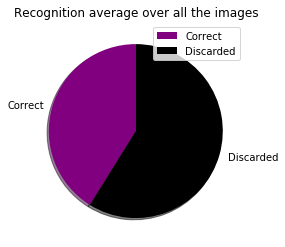

In [49]:
discarded = total_ignored/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-discarded), discarded]
print('Percentage of overall images that were discarded:', discarded)

plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()


Embeddings train: 20
Embeddings test: 20
Tolerance: 0.45


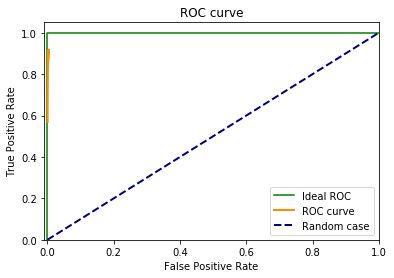

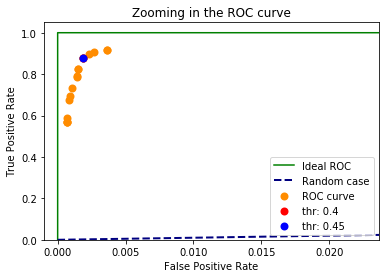

Threshold: 0.3 TAR: 0.8949283271483665 FAR 0.0022730174945728514
Threshold: 0.4 TAR: 0.8801571709233792 FAR 0.001864385135997957
Threshold: 0.45 TAR: 0.8757913119406243 FAR 0.001838845613587026
Threshold: 0.55 TAR: 0.825147347740668 FAR 0.0015196015834503895


In [20]:
log_basic_path = "./logs_0.45_areaMAX70/"
T_path = log_basic_path + "T/"
F_path = log_basic_path + "F/"
desc = "20_20_0.45"
plotROCcurve(T_path, F_path, desc)

In [ ]:
# an area lower that 50% of the maximum is refused
encodings_folder = "./encodings_20/"
test_path = "./encodings_20/"
key = "_areaMAX50"
total_frames_ = 0
total_ignored = 0
performTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -50)
performCrossedTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -50)

Percentage of overall images that were discarded: 0.31195593348171713


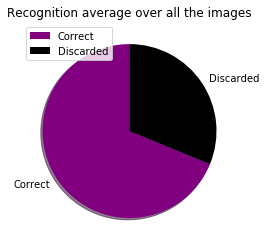

In [59]:
discarded = total_ignored/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-discarded), discarded]
print('Percentage of overall images that were discarded:', discarded)

plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()


Embeddings train: 20
Embeddings test: 20
Tolerance: 0.45


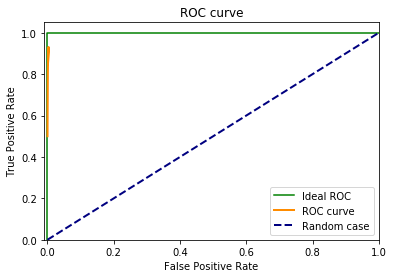

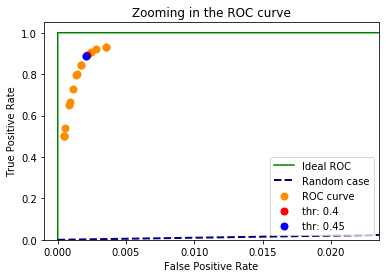

Threshold: 0.3 TAR: 0.9054201527828302 FAR 0.0024390243902439024
Threshold: 0.4 TAR: 0.8912331757002546 FAR 0.002119780360107266
Threshold: 0.45 TAR: 0.8873772280829393 FAR 0.0020814710764908697
Threshold: 0.55 TAR: 0.8424154237904693 FAR 0.0017366875239433022


In [21]:
log_basic_path = "./logs_0.45_areaMAX50/"
T_path = log_basic_path + "T/"
F_path = log_basic_path + "F/"
desc = "20_20_0.45"
plotROCcurve(T_path, F_path, desc)

In [ ]:
# an area lower that 50% of the maximum is refused
encodings_folder = "./encodings_20/"
test_path = "./encodings_20/"
key = "_areaMAX50"
total_frames_ = 0
total_ignored = 0
performTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.5, min_area = -50)
performCrossedTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.5, min_area = -50)

Percentage of overall images that were discarded: 0.31192378865333514


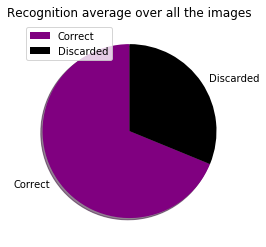

In [63]:
discarded = total_ignored/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-discarded), discarded]
print('Percentage of overall images that were discarded:', discarded)

plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

Embeddings train: 20
Embeddings test: 20
Tolerance: 0.5


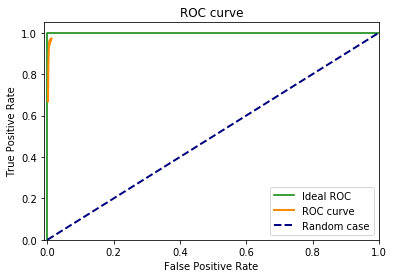

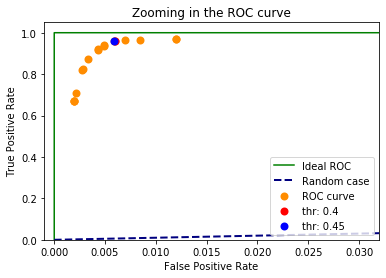

Threshold: 0.3 TAR: 0.9631138595853037 FAR 0.0069339803345677435
Threshold: 0.4 TAR: 0.9588941433248453 FAR 0.005950708721746903
Threshold: 0.45 TAR: 0.9580210985813022 FAR 0.00584855063210318
Threshold: 0.55 TAR: 0.9365587486358676 FAR 0.004878048780487805


In [22]:
log_basic_path = "./logs_0.5_areaMAX50/"
T_path = log_basic_path + "T/"
F_path = log_basic_path + "F/"
desc = "20_20_0.5"
plotROCcurve(T_path, F_path, desc)

In [ ]:
# an area lower that 50% of the maximum is refused / noise 0.25
encodings_folder = "./encodings_21/"
test_path = "./encodings_21/"
key = "_areaNOISE0.25"
total_frames_ = 0
total_ignored = 0
performTestENC_n(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.5, min_area = -50, min_noise = 0.25)
performCrossedTestENC_n(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.5, min_area = -50, min_noise = 0.25)

### 3. Face crop correction using percentage of local maximum face ratio with noise correction

Percentage of overall images that were discarded: 0.40082630043295475


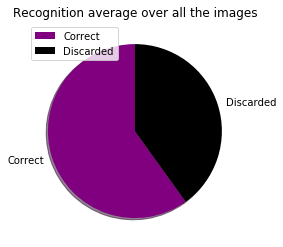

Due to noise correction: 0.08887036695123762 . Percentage: 0.2217179033792039


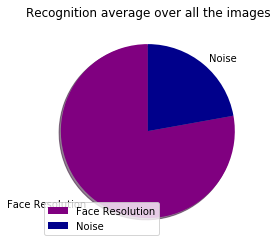

In [57]:
discarded = total_ignored/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-discarded), discarded]
print('Percentage of overall images that were discarded:', discarded)

plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

discarded_noise =  discarded - 0.31195593348171713
print("Due to noise correction:", discarded_noise , ". Percentage:", str(discarded_noise/discarded))
labels = ['Face Resolution', 'Noise']
colors = ['Purple', 'Darkblue']
sizes1 = [1-(discarded_noise/discarded), discarded_noise/discarded]

plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

Embeddings train: 21
Embeddings test: 21
Tolerance: 0.5


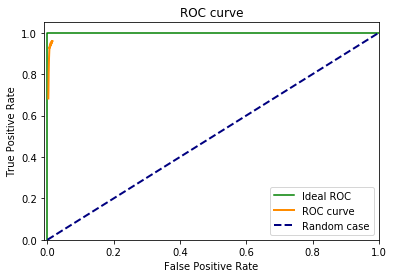

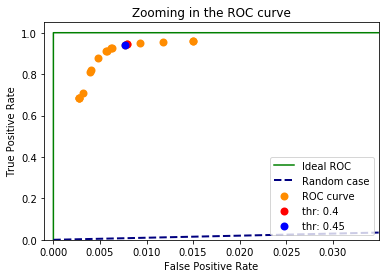

Threshold: 0.3 TAR: 0.9489996362313569 FAR 0.009321925679989785
Threshold: 0.4 TAR: 0.9433248453983266 FAR 0.007866172902566722
Threshold: 0.45 TAR: 0.9413604947253547 FAR 0.007725705529306602
Threshold: 0.55 TAR: 0.9260822117133503 FAR 0.006231643468267143


In [58]:
log_basic_path = "./logs_0.5_areaNOISE0.25/"
T_path = log_basic_path + "T/"
F_path = log_basic_path + "F/"
desc = "21_21_0.5"
plotROCcurve(T_path, F_path, desc)